# Mean-Variance Optimization

MPT solves for the optimal portfolio weights to minimize volatility for a given expected return, or maximize returns for a given level of volatility. The key requisite input are expected asset returns, standard deviations, and the covariance matrix. 

Diversification works because the variance of portfolio returns depends on the covariance of the assets and can be reduced below the weighted average of the asset variances by including assets with less than perfect correlation. In particular, given a vector, ω, of portfolio weights and the covariance matrix, $\Sigma$, the portfolio variance, $\sigma_{\text{PF}}$ is defined as:
$$\sigma_{\text{PF}}=\omega^T\Sigma\omega$$

Markowitz showed that the problem of maximizing the expected portfolio return subject to a target risk has an equivalent dual representation of minimizing portfolio risk subject to a target expected return level, $μ_{PF}$. Hence, the optimization problem becomes:
$$
\begin{align}
\min_\omega & \quad\quad\sigma^2_{\text{PF}}= \omega^T\Sigma\omega\\
\text{s.t.} &\quad\quad \mu_{\text{PF}}= \omega^T\mu\\ 
&\quad\quad \lVert\omega\rVert =1
\end{align}
$$

We can calculate an efficient frontier using `scipy.optimize.minimize` and the historical estimates for asset returns, standard deviations, and the covariance matrix. 

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

## Prepare Data

We select historical data for tickers included in the S&P500 (according to Wikipedia) from 1998-2017.

In [5]:
with pd.HDFStore('../data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks']

In [6]:
sp500_stocks.head()

,name,gics_sector,gics_sub_industry,location,first_added,cik,founded
ticker,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [7]:
with pd.HDFStore('../data/assets.h5') as store:
    prices = (store['quandl/wiki/prices']
              .adj_close
              .unstack('ticker')
              .filter(sp500_stocks.index)
              .sample(n=30, axis=1))

In [31]:
prices # prices for 30 random sp500 stocks

ticker,WDAY,CAT,GD,AMGN,STT,VMC,MAR,EXC,FSLR,WAT,...,NEE,SWK,SRE,BIIB,NI,HD,EFX,USB,RSG,MSFT
date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,1.578370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,1.593539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,1.634945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,1.650114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,1.660363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,133.43,155.800000,223.75,181.59,106.81,114.81,140.42,38.07,NaN,211.18,...,160.08,160.24,110.41,277.29,23.29,178.02,121.07,52.55,68.00,92.48
2018-03-22,131.22,146.900000,218.37,176.08,101.50,113.60,137.25,38.37,NaN,204.61,...,161.89,154.46,110.51,271.89,23.39,175.29,117.63,50.65,66.60,89.79
2018-03-23,127.64,144.290000,218.81,169.43,97.71,115.60,133.76,37.71,NaN,199.51,...,159.49,151.31,108.97,260.13,23.06,171.80,115.85,49.25,65.44,87.18


## Compute Inputs

### Compute Returns

In [9]:
start = 2008
end = 2017

Create month-end monthly returns and drop dates that have no observations:

In [10]:
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all') # get weekly returns using last price of week and subtracting previous week's last price
weekly_returns = weekly_returns.dropna(axis=1)
weekly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 2008-01-13 to 2017-12-31
Freq: W-SUN
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAT     521 non-null    float64
 1   GD      521 non-null    float64
 2   AMGN    521 non-null    float64
 3   STT     521 non-null    float64
 4   VMC     521 non-null    float64
 5   MAR     521 non-null    float64
 6   EXC     521 non-null    float64
 7   FSLR    521 non-null    float64
 8   WAT     521 non-null    float64
 9   ESS     521 non-null    float64
 10  CPT     521 non-null    float64
 11  HUM     521 non-null    float64
 12  RL      521 non-null    float64
 13  ACGL    521 non-null    float64
 14  UNP     521 non-null    float64
 15  MPWR    521 non-null    float64
 16  COF     521 non-null    float64
 17  A       521 non-null    float64
 18  NDAQ    521 non-null    float64
 19  NEE     521 non-null    float64
 20  SWK     521 non-null    float64
 21  SRE     

### Set  Parameters

In [11]:
weekly_returns

ticker,CAT,GD,AMGN,STT,VMC,MAR,EXC,FSLR,WAT,ESS,...,NEE,SWK,SRE,BIIB,NI,HD,EFX,USB,RSG,MSFT
date,,,,,,,,,,,,,,,,,,,,,
2008-01-13,-0.036772,0.006512,0.062946,0.011978,-0.033516,0.037903,0.024991,-0.100090,0.015353,0.038181,...,0.035455,0.037880,0.038506,0.068816,0.033298,-0.010016,-0.054795,0.013927,0.017851,-0.013671
2008-01-20,-0.042994,-0.063320,-0.003570,-0.105314,-0.037447,-0.005478,-0.097764,-0.204163,-0.069504,-0.008343,...,-0.106090,0.013035,-0.084226,0.015080,-0.077963,0.063537,0.007709,0.011390,-0.021840,-0.026541
2008-01-27,0.049674,0.004084,0.014542,0.059935,0.066303,0.038862,-0.036383,-0.026154,-0.220675,0.088786,...,-0.041287,-0.001072,-0.056021,-0.016525,0.012965,0.085616,0.055386,0.091752,-0.019959,-0.002121
2008-02-03,0.088427,0.051892,-0.016203,0.069409,0.099801,0.099264,0.059097,0.085591,0.062204,0.102389,...,0.069756,0.101760,0.053429,0.048201,0.078272,0.067298,0.072775,0.031553,0.043148,-0.075598
2008-02-10,-0.052258,-0.023084,-0.016892,-0.017030,-0.094359,-0.072347,-0.020021,-0.068571,-0.007588,-0.048607,...,-0.032144,-0.050468,-0.024044,-0.004210,-0.029781,-0.081445,-0.084324,-0.048824,0.001655,-0.062063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-03,0.030060,0.013200,0.041618,0.032663,-0.009075,0.002846,0.004804,0.000000,0.011278,-0.013300,...,0.009229,0.016507,0.014996,0.033595,0.010725,0.046945,0.027571,0.059232,0.030322,0.012011
2017-12-10,0.016535,-0.007748,-0.010102,0.022937,0.038528,0.019391,-0.018647,0.000000,0.005702,-0.011051,...,0.009907,-0.006341,-0.031458,0.020103,-0.006952,0.016572,0.039582,0.008379,0.014326,-0.001187
2017-12-17,0.019672,-0.011091,0.008494,0.008805,-0.040197,0.003866,-0.007552,0.000000,-0.013699,0.022431,...,-0.003773,-0.011631,-0.001371,0.006661,-0.023213,-0.004525,0.017973,-0.015535,0.014584,0.031963


In [27]:
stocks = weekly_returns.columns

In [12]:
n_obs, n_assets = weekly_returns.shape
n_assets, n_obs

(29, 521)

In [13]:
NUM_PF = 100000 # no of portfolios to simulate for mean-variance optimization

In [18]:
x0 = uniform(0, 1, n_assets)
print(x0)
x0 /= np.sum(x0)

[0.3483366  0.93664815 0.03918633 0.41794603 0.96758055 0.54797188
 0.42347094 0.56852028 0.57592458 0.73164776 0.12768973 0.25001645
 0.58054401 0.86711661 0.56186669 0.23859686 0.67984478 0.73990876
 0.23823615 0.37772889 0.53432747 0.49656119 0.38961809 0.29763517
 0.09998489 0.0534853  0.9585415  0.84714314 0.35490519]


In [19]:
x0

array([0.02444299, 0.06572516, 0.00274973, 0.02932752, 0.0678957 ,
       0.03845151, 0.02971521, 0.03989341, 0.04041297, 0.05134016,
       0.00896006, 0.0175438 , 0.04073712, 0.06084609, 0.03942652,
       0.01674248, 0.04770511, 0.05191984, 0.01671717, 0.02650546,
       0.03749408, 0.03484399, 0.02733973, 0.02088524, 0.007016  ,
       0.0037531 , 0.06726143, 0.05944454, 0.02490391])

### Annualization Factor

In [20]:
weekly_returns

ticker,CAT,GD,AMGN,STT,VMC,MAR,EXC,FSLR,WAT,ESS,...,NEE,SWK,SRE,BIIB,NI,HD,EFX,USB,RSG,MSFT
date,,,,,,,,,,,,,,,,,,,,,
2008-01-13,-0.036772,0.006512,0.062946,0.011978,-0.033516,0.037903,0.024991,-0.100090,0.015353,0.038181,...,0.035455,0.037880,0.038506,0.068816,0.033298,-0.010016,-0.054795,0.013927,0.017851,-0.013671
2008-01-20,-0.042994,-0.063320,-0.003570,-0.105314,-0.037447,-0.005478,-0.097764,-0.204163,-0.069504,-0.008343,...,-0.106090,0.013035,-0.084226,0.015080,-0.077963,0.063537,0.007709,0.011390,-0.021840,-0.026541
2008-01-27,0.049674,0.004084,0.014542,0.059935,0.066303,0.038862,-0.036383,-0.026154,-0.220675,0.088786,...,-0.041287,-0.001072,-0.056021,-0.016525,0.012965,0.085616,0.055386,0.091752,-0.019959,-0.002121
2008-02-03,0.088427,0.051892,-0.016203,0.069409,0.099801,0.099264,0.059097,0.085591,0.062204,0.102389,...,0.069756,0.101760,0.053429,0.048201,0.078272,0.067298,0.072775,0.031553,0.043148,-0.075598
2008-02-10,-0.052258,-0.023084,-0.016892,-0.017030,-0.094359,-0.072347,-0.020021,-0.068571,-0.007588,-0.048607,...,-0.032144,-0.050468,-0.024044,-0.004210,-0.029781,-0.081445,-0.084324,-0.048824,0.001655,-0.062063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-03,0.030060,0.013200,0.041618,0.032663,-0.009075,0.002846,0.004804,0.000000,0.011278,-0.013300,...,0.009229,0.016507,0.014996,0.033595,0.010725,0.046945,0.027571,0.059232,0.030322,0.012011
2017-12-10,0.016535,-0.007748,-0.010102,0.022937,0.038528,0.019391,-0.018647,0.000000,0.005702,-0.011051,...,0.009907,-0.006341,-0.031458,0.020103,-0.006952,0.016572,0.039582,0.008379,0.014326,-0.001187
2017-12-17,0.019672,-0.011091,0.008494,0.008805,-0.040197,0.003866,-0.007552,0.000000,-0.013699,0.022431,...,-0.003773,-0.011631,-0.001371,0.006661,-0.023213,-0.004525,0.017973,-0.015535,0.014584,0.031963


In [24]:
periods_per_year = round(weekly_returns.resample('A').size().mean()) # get the number of periods per year
periods_per_year

52

### Compute Mean Returns, Covariance and Precision Matrix

In [25]:
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()

The precision matrix is the inverse of the covariance matrix:

In [28]:
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

### Risk-Free Rate

Load historical 10-year Treasury rate:

In [33]:
web.DataReader('DGS10', 'fred', start, end)

,DGS10
DATE,
2008-01-01,NaN
2008-01-02,3.91
2008-01-03,3.91
2008-01-04,3.88
2008-01-07,3.86
...,...
2016-12-26,NaN
2016-12-27,2.57
2016-12-28,2.51


In [34]:
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year) # convert to weekly since yield is annualized
                         .div(100)
                         .squeeze())

In [35]:
rf_rate = treasury_10yr_monthly.mean()

In [36]:
rf_rate

0.0004989138176638178

## Simulate Random Portfolios

The simulation generates random weights using the Dirichlet distribution, and computes the mean, standard deviation, and SR for each sample portfolio using the historical return data:

In [37]:
n_assets

29

In [ ]:
# computing returns for simulated portfolios , and get their corresponding std dev and sharpe ratio. This is just doing monte carlo simulation of portfolios
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.05)
    weights = dirichlet(alpha=alpha, size=NUM_PF) # generate n_assets weights that sum to 1 , repeat NUM_PF times
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1 # expectation of portfolio returns
    returns = returns ** periods_per_year - 1 # turn weekly returns into annualized returns
    std = (weights @ weekly_returns.T).std(1) # first get portfolio returns on a weekly basis, then get std dev of those returns
    # this is not explictitly portoflio standard deviation formula but it is equivalent
    std *= np.sqrt(periods_per_year) # annualized standard deviation
    sharpe = (returns - rf_rate) / std # annualized sharpe ratio note: var(week1 + week2 + ... weekN) = N*var(week) assuming weeks are independent, thats why we multiply by sqrt(N)
    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

In [41]:
len(mean_returns)

29

In [42]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [43]:
df = pd.DataFrame(simul_wt)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,...,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,3.469883e-02,3.372541e-02,3.436590e-02,3.411326e-02,3.414214e-02,3.481879e-02,3.484040e-02,3.473586e-02,3.362366e-02,3.466654e-02,...,3.516147e-02,3.421907e-02,3.451091e-02,3.516487e-02,3.437790e-02,3.467926e-02,3.438038e-02,3.446947e-02,3.464681e-02,3.433012e-02
std,1.173319e-01,1.140384e-01,1.163695e-01,1.161368e-01,1.159239e-01,1.176967e-01,1.177677e-01,1.164497e-01,1.140729e-01,1.166205e-01,...,1.182730e-01,1.153998e-01,1.164667e-01,1.181513e-01,1.162743e-01,1.167872e-01,1.158445e-01,1.163537e-01,1.171257e-01,1.166125e-01
min,8.695327e-104,4.330900e-103,7.779923e-90,2.828240e-101,8.797320e-107,1.634923e-126,2.537581e-96,4.043422e-96,1.904525e-108,2.491785e-94,...,5.561050e-108,4.768452e-119,5.893455e-90,5.200901e-97,1.375516e-109,2.715600e-102,1.078537e-100,3.350640e-92,1.419187e-107,5.254589e-109
25%,6.073188e-13,5.617912e-13,5.952445e-13,5.135844e-13,5.299066e-13,5.327501e-13,5.744414e-13,6.572992e-13,4.945037e-13,5.430719e-13,...,5.175945e-13,5.528354e-13,5.953530e-13,6.359787e-13,7.040047e-13,5.504664e-13,5.600513e-13,6.313433e-13,5.751791e-13,6.561902e-13
50%,5.709863e-07,5.873018e-07,6.252972e-07,5.595816e-07,5.531221e-07,5.868851e-07,6.087554e-07,6.557930e-07,5.740699e-07,6.082527e-07,...,5.922339e-07,5.623066e-07,6.154871e-07,5.637671e-07,6.142248e-07,5.831202e-07,5.435209e-07,6.380546e-07,5.676516e-07,5.791763e-07
75%,1.907182e-03,1.937158e-03,1.882795e-03,1.823078e-03,1.923853e-03,1.971117e-03,1.923852e-03,2.099886e-03,1.932885e-03,1.968144e-03,...,2.020216e-03,1.913314e-03,2.026640e-03,1.916736e-03,1.866846e-03,1.918504e-03,1.947677e-03,2.013128e-03,1.866235e-03,1.896065e-03
max,9.943597e-01,9.915046e-01,9.998604e-01,9.974939e-01,9.959702e-01,9.998899e-01,9.984594e-01,9.954871e-01,9.982758e-01,9.980835e-01,...,9.981182e-01,9.990242e-01,9.980239e-01,9.958131e-01,9.956221e-01,9.959012e-01,9.966932e-01,9.959999e-01,9.988994e-01,9.983834e-01


### Plot Simulated Portfolios

In [44]:
simul_perf

,Annualized Standard Deviation,Annualized Returns,Sharpe Ratio
0,0.248761,0.135521,0.542777
1,0.246478,0.202047,0.817713
2,0.283769,0.198492,0.697727
3,0.220217,0.208696,0.945418
4,0.182484,0.185993,1.016491
...,...,...,...
99995,0.290419,0.191800,0.658705
99996,0.201491,0.158668,0.784996
99997,0.212173,0.193475,0.909524
99998,0.256265,0.216698,0.843655


Max Sharpe: 20.75%, 26.60%


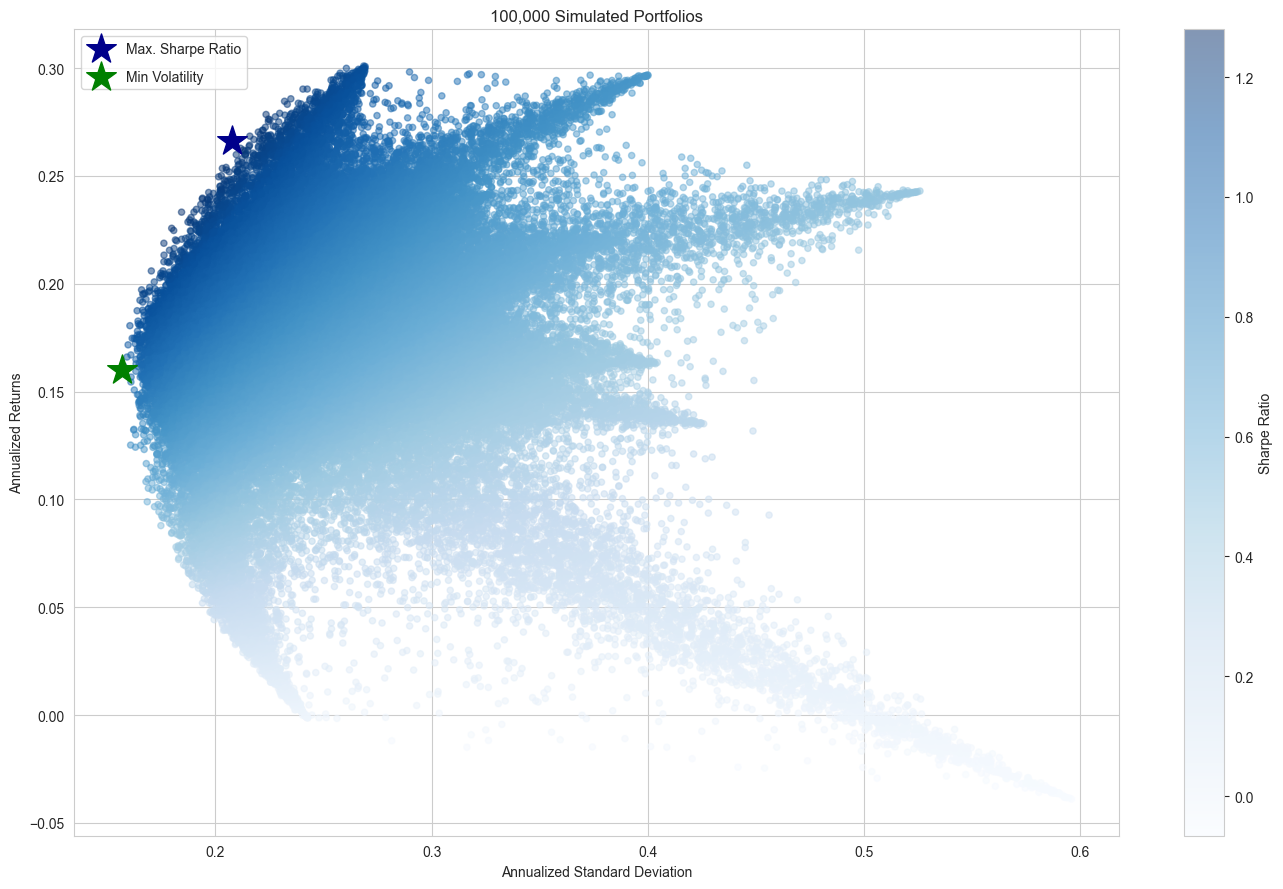

In [45]:
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Blues',
                             alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

## Compute Annualize PF Performance

Now we'll set up the quadratic optimization problem to solve for the minimum standard deviation for a given return or the maximum SR. 

To this end, define the functions that measure the key metrics:

In [46]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [47]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [48]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

## Max Sharpe PF

Define a target function that represents the negative SR for scipy's minimize function to optimize, given the constraints that the weights are bounded by [-1, 1], if short trading is permitted, and [0, 1] otherwise, and sum to one in absolute terms.

In [60]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

In [61]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x))-1} # if sum to 1, then return 0, which satisfies the eq constraint

In [62]:
x0

array([0.02444299, 0.06572516, 0.00274973, 0.02932752, 0.0678957 ,
       0.03845151, 0.02971521, 0.03989341, 0.04041297, 0.05134016,
       0.00896006, 0.0175438 , 0.04073712, 0.06084609, 0.03942652,
       0.01674248, 0.04770511, 0.05191984, 0.01671717, 0.02650546,
       0.03749408, 0.03484399, 0.02733973, 0.02088524, 0.007016  ,
       0.0037531 , 0.06726143, 0.05944454, 0.02490391])

In [63]:
def max_sharpe_ratio(mean_ret, cov, short=False):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0, # initial guess
                    args=(mean_ret, cov), # additional args to pass to neg_sharpe_ratio in addition to first arg which is weights
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint, # portfolio weights must sum to 1
                    options={'tol':1e-10, 'maxiter':1e4})

## Compute Efficient Frontier

The solution requires iterating over ranges of acceptable values to identify optimal risk-return combinations

In [51]:
def min_vol_target(mean_ret, cov, target, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq',
                    'fun': lambda x: ret_(x) - target}, # target return constraint, protfolio return should equal to target
                   weight_constraint] # and should sum to 1

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std, # minize portfolio standard deviation while maximizing return
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

The mean-variance frontier relies on in-sample, backward-looking optimization. In practice, portfolio optimization requires forward-looking input. Unfortunately, expected returns are notoriously difficult to estimate accurately.

The covariance matrix can be estimated somewhat more reliably, which has given rise to several alternative approaches. However, covariance matrices with correlated assets pose computational challenges since the optimization problem requires inverting the matrix. The high condition number induces numerical instability, which in turn gives rise to Markovitz curse: the more diversification is required (by correlated investment opportunities), the more unreliable the weights produced by the algorithm. 

## Min Volatility Portfolio

In [52]:
def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std, # get protfolio with minimum standard deviation, so the least risky portfolio
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [53]:
def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

## Run Calculation

### Get random PF

In [54]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [55]:
print(simul_perf.describe())

       Annualized Standard Deviation  Annualized Returns   Sharpe Ratio
count                  100000.000000       100000.000000  100000.000000
mean                        0.256794            0.173433       0.703717
std                         0.058632            0.046153       0.211316
min                         0.156938           -0.038672      -0.065864
25%                         0.214932            0.153187       0.588720
50%                         0.244623            0.175812       0.726894
75%                         0.284659            0.200861       0.844932
max                         0.595541            0.301129       1.273932


In [56]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation    0.185302
Annualized Returns               0.236562
Sharpe Ratio                     1.273932
Name: 27422, dtype: float64

### Get Max Sharpe PF

In [57]:
mean_returns

ticker
CAT     0.003238
GD      0.002631
AMGN    0.003446
STT     0.002438
VMC     0.002912
MAR     0.004168
EXC    -0.000031
FSLR   -0.000784
WAT     0.002454
ESS     0.003323
CPT     0.003565
HUM     0.003835
RL      0.002642
ACGL    0.003016
UNP     0.004020
MPWR    0.005017
COF     0.004193
A       0.002914
NDAQ    0.002453
NEE     0.002626
SWK     0.003837
SRE     0.002095
BIIB    0.004388
NI      0.003698
HD      0.005077
EFX     0.003250
USB     0.002907
RSG     0.002693
MSFT    0.002851
dtype: float64

In [64]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [65]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.238669
sd     0.177514
sr     1.341702
dtype: float64

From simulated pf data

### Get Min Vol PF

In [66]:
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

### Get Efficent PFs

In [ ]:
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50) # range of returns for efficient frontier, generate 50 points evenly spaced between min and max returns from simulated portfolios
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True) # given a range of returns, get the efficient frontier portfolios that minimize volatility for each return in the range
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range))) # we should get 50 portfolios on the efficient frontier

### Plot Result

The simulation yields a subset of the feasible portfolios, and the efficient frontier identifies the optimal in-sample return-risk combinations that were achievable given historic data. 

The below figure shows the result including the minimum variance portfolio and the portfolio that maximizes the SR and several portfolios produce by alternative optimization strategies. The efficient frontier 

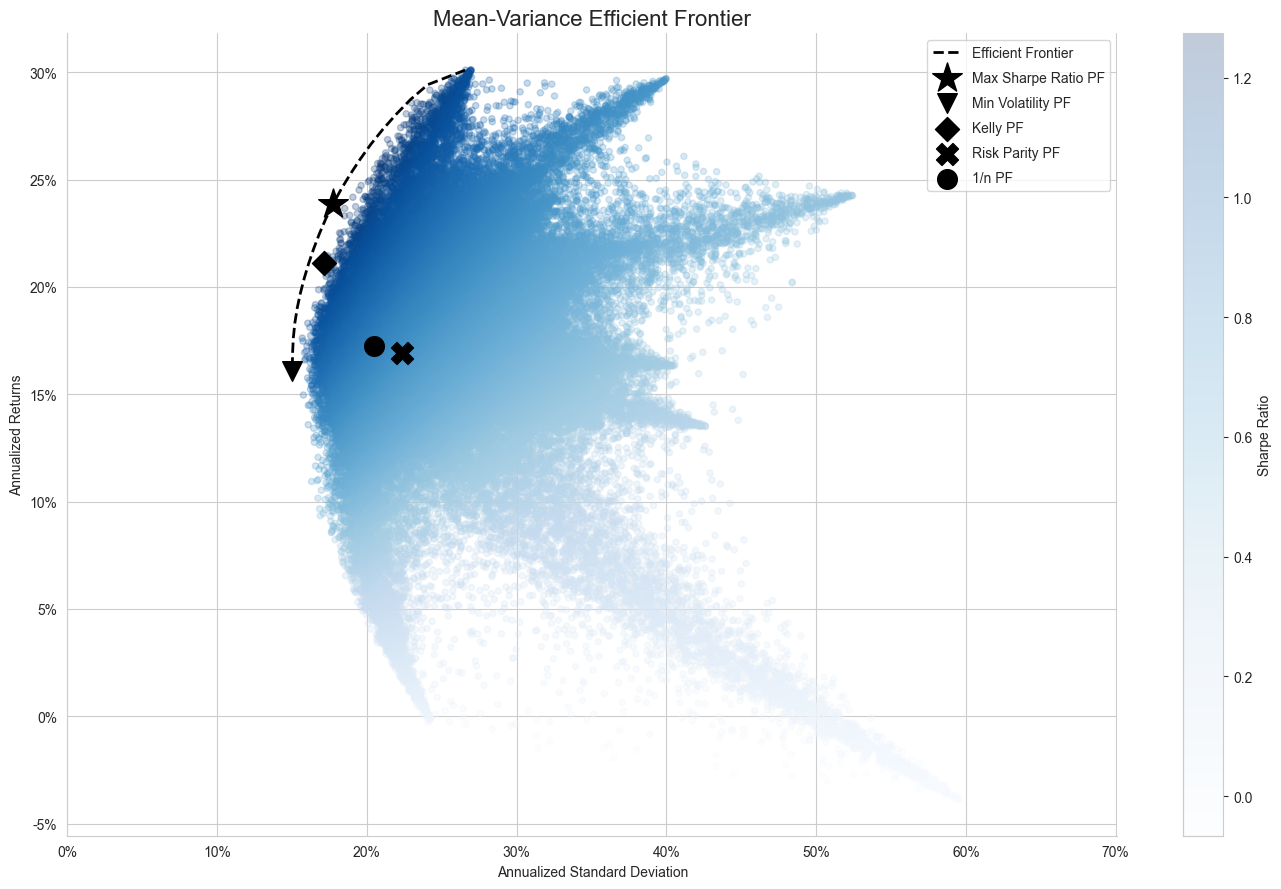

In [68]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25, 
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k',
                                 label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')


ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();